# M03. Base Running
- This predicts errors, double plays, out locations, and baserunner advancements
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 12/16/2023
- Updated: 2/5/2025

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Data

##### MLB Stats API

Notes: 
- This cannot use the same complete dataset as elsewhere because multiple records per plate appearance are required and those are typically dropped
- MLB Stats API calls are highly prone to connection errors. Because of this, it's highly discouraged to run them all in parallel. Sadly, the below approach is the best I've got.

Create yearly dataframes

In [3]:
# df2015 = plays_statsapi("04/01/2015", "10/31/2015")
# df2016 = plays_statsapi("04/01/2016", "10/31/2016")
# df2017 = plays_statsapi("04/01/2017", "10/31/2017")
# df2018 = plays_statsapi("04/01/2018", "10/31/2018")
# df2019 = plays_statsapi("04/01/2019", "10/31/2019")
# df2020 = plays_statsapi("04/01/2020", "10/31/2020")
# df2021 = plays_statsapi("04/01/2021", "10/31/2021")
# df2022 = plays_statsapi("04/01/2022", "10/31/2022")
# df2023 = plays_statsapi("04/01/2023", "10/31/2023")
# df2024 = plays_statsapi("04/01/2024", "10/31/2024")

Concatenate yearly dataframes

In [4]:
# running_dataset = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020, df2021, df2022, df2023, df2024], axis=0).query('game_type == "R"')

Write to CSV

In [5]:
# running_dataset.to_csv(os.path.join(baseball_path, "Running Dataset.csv"), index=False)

Read CSV

In [6]:
running_dataset = pd.read_csv(os.path.join(baseball_path, "Running Dataset.csv"))

In [7]:
running_dataset['year'] = running_dataset['game_date'].str[:4].astype(int)

##### Steamer

In [8]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

Clean

In [9]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

### Movement Reasons

r_adv_force: advanced on a ball in play because they were forced to <br>
r_adv_play: advanced on a ball in play without being forced to <br>
r_force_out: out on a force play <br>
r_adv_throw: advanced on the throw, not the contact <br>
r_runner_out: out not on a force play <br>
r_thrown_out: out on a hit (base runner) <br>
r_doubled_off: out on a ball caught and thrown to base <br>
r_out_stretching: out on a hit (hitter) <br>

We now have where every runner, including the batter, started and finished. However, we have two problems:
- Some base runners don't move. They are not included in the dataset yet. 
- Some base runners move more than once in a play. They may go from 1B to 2B on a hit and then 2B to 3B on a throw.

### Multiple Movements

Identify where a runner starts and ends in an at bat. Only keep one instance. 

In [10]:
# Determine start and end base by number
# 0 is AB, 1 is 1B, 2 is 2B, 3 is 3B, 4 is scored, 5 is out
running_dataset['startInt'] = running_dataset['start'].apply(lambda x: 0 if pd.isna(x) else int(x[0]) if x[0].isdigit() else 0)
running_dataset['endInt'] = running_dataset['end'].apply(lambda x: 5 if pd.isna(x) else 4 if x.lower() == 'score' else int(x[0]) if x[0].isdigit() else 0)

In [11]:
running_dataset['minBase'] = running_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['startInt'].transform('min')
running_dataset['maxBase'] = running_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['endInt'].transform('max')

In [12]:
# Extract the number after "id" using regular expression
running_dataset['postOnFirst'] = running_dataset['postOnFirst'].str.extract(r"'id': (\d+)")
running_dataset['postOnSecond'] = running_dataset['postOnSecond'].str.extract(r"'id': (\d+)")
running_dataset['postOnThird'] = running_dataset['postOnThird'].str.extract(r"'id': (\d+)")

In [13]:
# Determine where runners were to start PA
# Note that the exact id may be incorrect due to pinch runners, but we don't really care.
running_dataset['preOnFirst'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnFirst'].shift(1)
running_dataset['preOnSecond'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnSecond'].shift(1)
running_dataset['preOnThird'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnThird'].shift(1)

for col in ['preOnFirst', 'preOnSecond', 'preOnThird']:
    first_vals = (
        running_dataset
        .groupby(['gamePk', 'atBatIndex'])
        .head(1)
        .set_index(['gamePk', 'atBatIndex'])[col]
    )

    running_dataset[col] = (
        running_dataset
        .set_index(['gamePk', 'atBatIndex'])
        .index.map(first_vals)
    )

In [14]:
# # Determine where runners were to start PA
# # Note that the exact id may be incorrect due to pinch runners, but we don't really care.
# running_dataset['preOnFirst'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnFirst'].shift(1)
# running_dataset['preOnSecond'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnSecond'].shift(1)
# running_dataset['preOnThird'] = running_dataset.groupby(['gamePk', 'halfInning'])['postOnThird'].shift(1)

# # Create a mask to identify the first occurrence of each combination
# first_occurrence_mask = ~running_dataset.duplicated(subset=['gamePk', 'atBatIndex'], keep='first')

# # Set 'preOnFirst' to NaN for non-first occurrences
# running_dataset['preOnFirst'] = running_dataset['preOnFirst'].where(first_occurrence_mask, other=None)
# running_dataset['preOnSecond'] = running_dataset['preOnSecond'].where(first_occurrence_mask, other=None)
# running_dataset['preOnThird'] = running_dataset['preOnThird'].where(first_occurrence_mask, other=None)
# # Fill in missings
# running_dataset['preOnFirst'] = running_dataset.groupby(['gamePk', 'atBatIndex'])['preOnFirst'].ffill()
# running_dataset['preOnSecond'] = running_dataset.groupby(['gamePk', 'atBatIndex'])['preOnSecond'].ffill()
# running_dataset['preOnThird'] = running_dataset.groupby(['gamePk', 'atBatIndex'])['preOnThird'].ffill()

In [16]:
conditions = [
    running_dataset['movementReason'].isin(['r_stolen_base_2b', 'r_stolen_base_3b']),
    running_dataset['movementReason'].isin(['r_caught_stealing_2b', 'r_pickoff_caught_stealing_2b',
                                            'r_caught_stealing_3b', 'r_pickoff_caught_stealing_3b'])
]

choices = [2, 1]

running_dataset['priority'] = np.select(conditions, choices, default=0)

### Base Runners

In [24]:
atBat = running_dataset.query('id == batter')

# Only keep runners at bat
atBat.sort_values(['gamePk', 'atBatIndex', 'runner_id', 'priority'], ascending=[True, True, True, False], inplace=True)
atBat.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

##### Runners on 1B

In [19]:
on1B = running_dataset[~running_dataset['preOnFirst'].isna()]

# Step 1: Create a dummy column is_runner = 1 if runner starts on that base
on1B['is_runner'] = (on1B['start'] == "1B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on1B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnFirst for instances where there are no runners
on1B.loc[no_runner_mask, 'id'] = on1B.loc[no_runner_mask, 'preOnFirst']
on1B.loc[no_runner_mask, 'runner_id'] = on1B.loc[no_runner_mask, 'preOnFirst']

# Step 4: Create the added_1b column
on1B['added_1b'] = 0
on1B.loc[no_runner_mask, 'added_1b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_1b == 1
on1B.loc[on1B['added_1b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 1
on1B.loc[on1B['added_1b'] == 1, ['start', 'end']] = "1B"

# Step 6: Keep one observation per runner
on1B.sort_values(['gamePk', 'atBatIndex', 'runner_id', 'priority'], ascending=[True, True, True, False], inplace=True)
on1B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on1B = on1B.query('minBase == 1')

##### Runners on 2B

In [20]:
on2B = running_dataset[~running_dataset['preOnSecond'].isna()]

# Step 1: Create a dummy column is_runner = 1 if runner starts on that base
on2B['is_runner'] = (on2B['start'] == "2B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on2B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preOnSecond for instances where there are no runners
on2B.loc[no_runner_mask, 'id'] = on2B.loc[no_runner_mask, 'preOnSecond']
on2B.loc[no_runner_mask, 'runner_id'] = on2B.loc[no_runner_mask, 'preOnSecond']

# Step 4: Create the added_2b column
on2B['added_2b'] = 0
on2B.loc[no_runner_mask, 'added_2b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_2b == 1
on2B.loc[on2B['added_2b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 2
on2B.loc[on2B['added_2b'] == 1, ['start', 'end']] = "2B"

# Step 6: Keep one observation per runner
on2B.sort_values(['gamePk', 'atBatIndex', 'runner_id', 'priority'], ascending=[True, True, True, False], inplace=True)
on2B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on2B = on2B.query('minBase == 2')

##### Runners on 3B

In [21]:
on3B = running_dataset[~running_dataset['preOnThird'].isna()]

# Step 1: Create a dummy column is_runner = 1 if runner starts on that base
on3B['is_runner'] = (on3B['start'] == "3B").astype(int)

# Step 2: Identify instances where there are no observations for which is_runner = 1
no_runner_mask = ~on3B.groupby(['gamePk', 'atBatIndex'])['is_runner'].transform('max').astype(bool)

# Step 3: Set id = preThird for instances where there are no runners
on3B.loc[no_runner_mask, 'id'] = on3B.loc[no_runner_mask, 'preOnThird']
on3B.loc[no_runner_mask, 'runner_id'] = on3B.loc[no_runner_mask, 'preOnThird']

# Step 4: Create the added_3b column
on3B['added_3b'] = 0
on3B.loc[no_runner_mask, 'added_3b'] = 1

# Step 5: Set startInt, endInt, minBase, maxBase for added_3b == 1
on3B.loc[on3B['added_3b'] == 1, ['startInt', 'endInt', 'minBase', 'maxBase']] = 3
on3B.loc[on3B['added_3b'] == 1, ['start', 'end']] = "3B"

# Step 6: Keep one observation per runner
on3B.sort_values(['gamePk', 'atBatIndex', 'runner_id', 'priority'], ascending=[True, True, True, False], inplace=True)
on3B.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

# Step 7: Only keep runners on specified base
on3B = on3B.query('minBase == 3')

##### Combine

In [25]:
# Concatenate the original DataFrame with the modified rows
df = pd.concat([atBat, on1B, on2B, on3B], axis=0, ignore_index=True)

# Count up observations within an atBatIndex
df['atBatIndexNum'] = df.groupby(['gamePk', 'atBatIndex']).cumcount() + 1

# Sort
df.sort_values(['gamePk', 'atBatIndex', 'atBatIndexNum'], inplace=True)

##### Start Locations

In [26]:
# Any runner started on these bases
# Create start location dummies
df['pre_1b'] = (df['minBase'] == 1).astype('int')
df['pre_2b'] = (df['minBase'] == 2).astype('int')
df['pre_3b'] = (df['minBase'] == 3).astype('int')

# Group by 'gamePk' and 'atBatIndex', then use transform to calculate the max for each group
df['pre_1b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_1b'].transform('max')
df['pre_2b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_2b'].transform('max')
df['pre_3b'] = df.groupby(['gamePk', 'atBatIndex'])['pre_3b'].transform('max')

##### Fix End Locations

In [27]:
# End locations: Runner
df['post_1b'] = (df['maxBase'] == 1).astype('int')
df['post_2b'] = (df['maxBase'] == 2).astype('int')
df['post_3b'] = (df['maxBase'] == 3).astype('int')

# End locations: At Bat (team)
df['post_1b'] = df.groupby(['gamePk', 'atBatIndex'])['post_1b'].transform('max')
df['post_2b'] = df.groupby(['gamePk', 'atBatIndex'])['post_2b'].transform('max')
df['post_3b'] = df.groupby(['gamePk', 'atBatIndex'])['post_3b'].transform('max')

# End locations: Blocked - this occurs when someone other than the runner is already on a base
# Note: You can't be blocked from advancing to a base you're on or have passed
df['blocked_1b'] = ((df['post_1b'] == 1) & (df['maxBase'] < 1)).astype('int')
df['blocked_2b'] = ((df['post_2b'] == 1) & (df['maxBase'] < 2)).astype('int')
df['blocked_3b'] = ((df['post_3b'] == 1) & (df['maxBase'] < 3)).astype('int')

##### Events

In [28]:
# Create game events
df = create_events(df)

# Encode events as integer
df['eventsModelInt'] = df['eventsModel'].map({'b1': 1, 'b2': 2, 'b3': 3, 'hr': 4, 'bb': 5, 'hbp': 6, 'so': 7, 'fo': 8, 'go': 9, 'lo': 10, 'po': 11})

##### Out locations

In [29]:
# Determine if a runner is out
df['out'] = (df['maxBase'] == 5).astype('int')

df['out_home'] = ((df['out'] == 1) & (df['minBase'] == 0)).astype('int')
df['out_1b'] = ((df['out'] == 1) & (df['minBase'] == 1)).astype('int')
df['out_2b'] = ((df['out'] == 1) & (df['minBase'] == 2)).astype('int')
df['out_3b'] = ((df['out'] == 1) & (df['minBase'] == 3)).astype('int')

df['out_home'] = df.groupby(['gamePk', 'atBatIndex'])['out_home'].transform('max')
df['out_1b'] = df.groupby(['gamePk', 'atBatIndex'])['out_1b'].transform('max')
df['out_2b'] = df.groupby(['gamePk', 'atBatIndex'])['out_2b'].transform('max')
df['out_3b'] = df.groupby(['gamePk', 'atBatIndex'])['out_3b'].transform('max')

##### Merge

In [30]:
df['date'] = df['game_date'].str.replace("-", "").astype(int)
steamer_hitters_df2['date'] = steamer_hitters_df2['date'].astype(int)

In [31]:
df['runner_id'] = df['runner_id'].astype(int)
steamer_hitters_df2['mlbamid'] = steamer_hitters_df2['mlbamid'].astype(int)

In [32]:
# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
steamer_hitters_df2['date'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')

# Sort both DataFrames by the date column
df = df.sort_values(['runner_id', 'date'])
steamer_hitters_df2 = steamer_hitters_df2.sort_values(['mlbamid', 'date'])

# Perform an asof merge on date while grouping by runner_id/mlbamid
df = pd.merge_asof(
    df.sort_values('date'),  # Ensure sorting
    steamer_hitters_df2[['mlbamid', 'date', 'sb', 'sbo', 'sba']].sort_values('date'),
    left_on='date',
    right_on='date',
    left_by='runner_id',
    right_by='mlbamid'
)

In [33]:
df.sort_values(['gamePk', 'atBatIndex'], inplace=True)

### Create Variables

Determine year

In [34]:
df['year'] = df["game_date"].astype('str').str[:4].astype('int')

Bottom of the inning dummy

In [35]:
df['bottom'] = (df['halfInning'] == "bottom").astype('int')

Calculate number of outs on play

In [36]:
df['outs_calculated'] = df.groupby(['gamePk', 'atBatIndex'])['out'].transform('sum')

Calculate number of outs prior to PA

In [37]:
df['outs_pre'] = df.groupby(['gamePk', 'inning', 'bottom'])['outs'].shift(1)
df['outs_pre'] = df.groupby(['gamePk', 'atBatIndex'])['outs_pre'].transform('min')
df['outs_pre'] = np.where(df['outs_pre'] == 3, 0, df['outs_pre'])

df['outs_pre'].fillna(0, inplace=True)

,bottom,atBatIndex,runner_id,outs,outs_pre
234,0,0,594777,1,0.0000
1560,0,1,545361,1,1.0000
1172,0,2,405395,2,1.0000
1285,0,3,459964,3,2.0000
778,1,4,457706,1,0.0000
506,1,5,452234,1,1.0000
507,1,6,452234,2,1.0000
682,1,6,429664,2,1.0000
508,1,7,452234,3,2.0000
759,1,7,443558,3,2.0000


Identify errors

In [38]:
df['error'] = df['description'].fillna("Missing").str.contains('error', case=False).astype('int')
df['error'] = np.where((df['outs_calculated'] == 0) & (df['eventType'] == 'fielders_choice'), 1, df['error'])

Identify double plays

In [39]:
df['double_play'] = df['eventType'].isin(['grounded_into_double_play', 'double_play', 'sac_fly_double_play', 'strikeout_double_play', 'sac_bunt_double_play']).astype(int)
df['double_play'] = np.where(df['outs_calculated'] == 2, 1, df['double_play'])

Identify steals

In [40]:
df['sb_2b'] = df['movementReason'].isin(['r_stolen_base_2b']).astype('int') 
df['sb_3b'] = df['movementReason'].isin(['r_stolen_base_3b']).astype('int') 
df['sba_2b'] = df['movementReason'].isin(['r_stolen_base_2b', 'r_caught_stealing_2b', 'r_pickoff_caught_stealing_2b']).astype('int') 
df['sba_3b'] = df['movementReason'].isin(['r_stolen_base_3b', 'r_caught_stealing_3b', 'r_pickoff_caught_stealing_3b']).astype('int') 

Calculate imputed stolen base attempt and success rates

In [41]:
df['sba_imp'] = df['sba'] / df['sbo']
df['sb_imp'] = df['sb'] / df['sba']

Create dummies

In [42]:
event_dummies = pd.get_dummies(df[df['eventsModel'] != "Cut"]['eventsModel'], prefix='event').astype(int)
minBase_dummies = pd.get_dummies(df['minBase'], prefix='minBase').astype(int)

df = pd.concat([df, event_dummies, minBase_dummies], axis=1)

### Select Data

Drop duplicates (these shouldn't really occur because they imply two players were on the same base to start a PA. Only one case)

In [43]:
df.drop_duplicates(subset=['gamePk', 'atBatIndex', 'minBase'], keep='first', inplace=True)

Drop triple plays

In [44]:
df = df.query('outs_calculated != 3')

Identify atypical movement (to be dropped in base running models)

In [45]:
# Typical movements
movementReason_list = ['r_adv_force', 'r_adv_play', 'r_force_out', 'r_adv_throw', 'r_runner_out', 'r_thrown_out', 'r_doubled_off', 'r_out_stretching']
df['movementTypical'] = df['movementReason'].apply(lambda x: 1 if x in movementReason_list or pd.isna(x) else 0)
# Apply to whole at bat. We'll only keep those for which all movement is typical.
df['movementTypical'] = df.groupby(['gamePk', 'atBatIndex'])['movementTypical'].transform('min')

### Base Running Models

##### Errors

In [ ]:
error_input_list = list(event_dummies.columns) + ['pre_1b', 'pre_2b', 'pre_3b']
# Removed outs_pre because of small sample sizes with specific combinations could lead to high error rates

In [ ]:
%%time
# Select relevant columns and handle missing values
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('startInt == 0')[error_input_list]
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('startInt == 0')['error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_state = 10

models = [
    MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+1),
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+2),
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_errors = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_errors.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_errors.classes_
probability_columns = [f'error_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
error_df = pd.concat([X_test, y_test, probability_df], axis=1)
# error_df['eventsModel'] = label_encoder.inverse_transform(error_df['eventsModelInt'])

# Create directory
os.makedirs(os.path.join(model_path, "M04. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_errors, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_errors.sav"), 'wb'))

In [ ]:
print(error_df[['error_1', 'error']].mean())

quantiles = 20

# Set Variable
var = "error"

# Copy 
graph_df = error_df.copy()

# Step 1: Divide error_1 into 
graph_df['quantile'] = pd.qcut(graph_df[f'{var}_1'], quantiles, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_quantiles = graph_df.groupby('quantile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Quantiles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Quantile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


##### Double Play

In [ ]:
double_play_input_list = list(event_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b']

In [ ]:
%%time
# Select relevant columns and handle missing values
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('minBase == 0')[double_play_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('minBase == 0')['double_play']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
models = [
    MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=1),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=2),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_dp = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_dp.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_dp.classes_
probability_columns = [f'double_play_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
dp_df = pd.concat([X_test, y_test, probability_df], axis=1)
# events_df['eventsModel'] = label_encoder.inverse_transform(base_df['eventsModelInt'])

# Create directory
os.makedirs(os.path.join(model_path, "M04. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_dp, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_dp.sav"), 'wb'))

In [ ]:
print(dp_df[['double_play_1', 'double_play']].mean())

# Set Variable
var = "double_play"

# Copy 
graph_df = dp_df.copy()

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Decile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


##### Out Bases

In [ ]:
out_input_list = list(event_dummies.columns) + list(minBase_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'error', 'double_play']

In [ ]:
%%time
# Select relevant columns and handle missing values
X = df.query('eventsModel != "Cut"').query('movementTypical == 1')[out_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1')['out']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=4),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=5),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=6)
    ]

# Create the ensemble classifier using VotingClassifier
predict_out_bases = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)



# model_out_bases = MLPClassifier(hidden_layer_sizes=(30,30), activation='relu', max_iter=10, random_state=42)
# model_out_bases.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_out_bases.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_out_bases.classes_
probability_columns = [f'out_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
outs_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M04. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_out_bases, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_out_bases.sav"), 'wb'))

In [ ]:
# Set Variable
var = "out"

# Copy 
graph_df = outs_df.copy()

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Decile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
outs_df.query('(event_b1 == 1 or event_b2 == 1 or event_b3 == 1 or event_bb == 1 or event_hbp == 1)')[['out', 'out_1']].mean()

In [ ]:
outs_df.query('minBase_0 == 1')[['out', 'out_1']].mean()

In [ ]:
outs_df[['out', 'out_1']].mean()

##### Base

In [ ]:
event_input_list = list(event_dummies.columns) + list(minBase_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'blocked_1b', 'blocked_2b', 'blocked_3b', 'out_home', 'out_1b', 'out_2b', 'out_3b', 'error', 'double_play']

In [ ]:
%%time
# Select relevant columns and handle missing values
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('out == 0')[event_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('out == 0')['maxBase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create and train the MLPClassifier
# model_events = MLPClassifier(hidden_layer_sizes=(40,), activation='relu', max_iter=10, random_state=2)

random_state = 10000000

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+1),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+2),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+3),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+4),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+5)
    ]

# Create the ensemble classifier using VotingClassifier
predict_events = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_events.predict_proba(X_test)

# Create DataFrame from probabilities
probability_columns = [f'base_{label}' for label in predict_events.classes_]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
events_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M04. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_events, open(os.path.join(model_path, "M04. Base Running", todaysdate, "predict_events.sav"), 'wb'))

In [ ]:
# Set Variables
var = "base"
origin_base = 2
destination_base = 4
event = "b1"
# This one is a little confusing, but it basically shows the probability of ending up at a given base by event type.

# Copy 
graph_df = events_df.copy()
graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

# Step 1: Divide error_1 into deciles
graph_df['decile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

# Step 2 & 3: Group by deciles and calculate average error_1 and error
grouped_deciles = graph_df.groupby('decile').agg({f'{var}_{destination_base}': 'mean', 'base_dummy': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
plt.plot(grouped_deciles['decile'], grouped_deciles[f'base_dummy'], marker='x', label='Average (Actual)')
plt.xlabel('Deciles (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Deciles, {var} == {origin_base} -> {destination_base}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define configurations for the 2x2 grid
configs = [
    {"origin_base": 1, "destination_base": 3, "event": "b1"},
    {"origin_base": 2, "destination_base": 4, "event": "b1"},
    {"origin_base": 1, "destination_base": 4, "event": "b2"},
    {"origin_base": 3, "destination_base": 4, "event": "fo"},
]

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

# Iterate through configurations and axes
for i, config in enumerate(configs):
    origin_base = config["origin_base"]
    destination_base = config["destination_base"]
    event = config["event"]
    var = "base"

    # Copy and filter data
    graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
    graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

    # Divide error_1 into deciles
    graph_df['decile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

    # Group by deciles and calculate averages
    grouped_deciles = graph_df.groupby('decile').agg({
        f'{var}_{destination_base}': 'mean', 
        'base_dummy': 'mean'
    }).reset_index()

    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(grouped_deciles['decile'], grouped_deciles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
    ax.plot(grouped_deciles['decile'], grouped_deciles[f'base_dummy'], marker='x', label='Average (Actual)')
    ax.set_title(f'{var}: {origin_base} -> {destination_base}, Event: {event}')
    ax.set_xlabel('Deciles (Projected)')
    ax.set_ylabel('Average')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
events_df['to_1b'] = (events_df['maxBase'] == 1).astype(int)
events_df['to_2b'] = (events_df['maxBase'] == 2).astype(int)
events_df['to_3b'] = (events_df['maxBase'] == 3).astype(int)
events_df['to_home'] = (events_df['maxBase'] == 4).astype(int)

In [ ]:
print(f"2B -> H on a Single: {events_df.query('event_b1 == 1 and minBase_2 == 1')['base_4'].mean()}, {events_df.query('event_b1 == 1 and minBase_2 == 1')['to_home'].mean()}")
print(f"1B -> H on a Double: {events_df.query('event_b2 == 1 and minBase_1 == 1')['base_4'].mean()}, {events_df.query('event_b2 == 1 and minBase_1 == 1')['to_home'].mean()}")
print(f"1B -> 3B on a Single: {events_df.query('event_b1 == 1 and minBase_1 == 1')['base_3'].mean()}, {events_df.query('event_b1 == 1 and minBase_1 == 1')['to_3b'].mean()}")
print(f"3B -> H on a FO: {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['base_4'].mean()}, {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['to_home'].mean()}")

### Stolen Base Models

##### Attempt to Steal 2B

In [51]:
cutoff = 30
input_list = ['outs_pre', 'sba_imp', 'sb_imp']

In [52]:
df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query('year >= 2015')[input_list].describe()

,outs_pre,sba_imp,sb_imp
count,258976.0000,258976.0000,258976.0000
mean,1.1032,0.0913,0.6855
std,0.7980,0.0766,0.0523
min,0.0000,0.0031,0.5670
25%,0.0000,0.0353,0.6410
50%,1.0000,0.0676,0.6890
75%,2.0000,0.1275,0.7200
max,2.0000,0.6590,0.8480


In [72]:
%%time
# Select relevant columns and handle missing values
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query('year >= 2024')[input_list]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query('year >= 2024')['sba_2b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
predict_sba_2b = MLPClassifier(hidden_layer_sizes=(4,4,4), activation='relu', early_stopping=False, max_iter=100, random_state=1200000)
predict_sba_2b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_sba_2b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sba_2b_not', 'sba_2b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M05. Steals", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sba_2b, open(os.path.join(model_path, "M05. Steals", todaysdate, "predict_sba_2b.sav"), 'wb'))

CPU times: total: 5.77 s
Wall time: 5.81 s


In [73]:
quantiles = 10

# Add xtiles (to examine how well predictions match actual results)
sba_2b_df['quantile'] = pd.qcut(sba_2b_df['sba_2b_pred'], quantiles, labels=False)
globals()["sba_2b_df_quantiles"] = sba_2b_df.groupby('quantile')[['sba_2b', 'sba_2b_pred']].mean().reset_index()

sba_2b_pred   0.0920
sba_2b        0.0909
dtype: float64


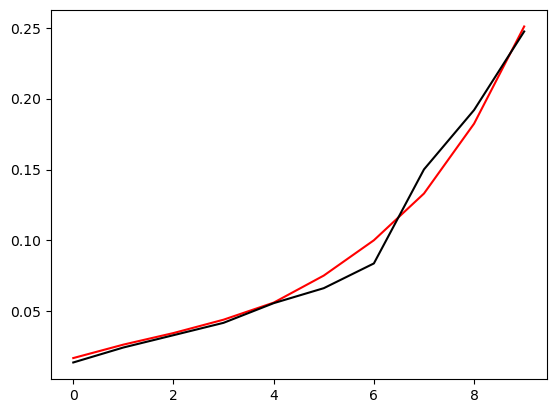

In [74]:
print(sba_2b_df[['sba_2b_pred', 'sba_2b']].mean())

# Create figures
plt.plot(sba_2b_df_quantiles['quantile'], sba_2b_df_quantiles['sba_2b_pred'], color='red')
plt.plot(sba_2b_df_quantiles['quantile'], sba_2b_df_quantiles['sba_2b'], color='black')
plt.show() 

##### Attempt to Steal 3B

In [66]:
%%time
# Select relevant columns and handle missing values
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and minBase == 2').query('year >= 2024')[['outs_pre', 'sba_imp', 'sb_imp']]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and minBase == 2').query('year >= 2024')['sba_3b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
predict_sba_3b = MLPClassifier(hidden_layer_sizes=(40,40), activation='relu', early_stopping=False, max_iter=100, random_state=21000)
predict_sba_3b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_sba_3b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sba_3b_not', 'sba_3b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M05. Steals", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sba_3b, open(os.path.join(model_path, "M05. Steals", todaysdate, "predict_sba_3b.sav"), 'wb'))

CPU times: total: 6 s
Wall time: 5.71 s


In [67]:
quantiles = 10 

# Add xtiles (to examine how well predictions match actual results)
sba_3b_df['quantile'] = pd.qcut(sba_3b_df['sba_3b_pred'], quantiles, labels=False)
globals()["sba_3b_df_quantiles"] = sba_3b_df.groupby('quantile')[['sba_3b', 'sba_3b_pred']].mean().reset_index()

sba_3b_pred   0.0186
sba_3b        0.0183
dtype: float64


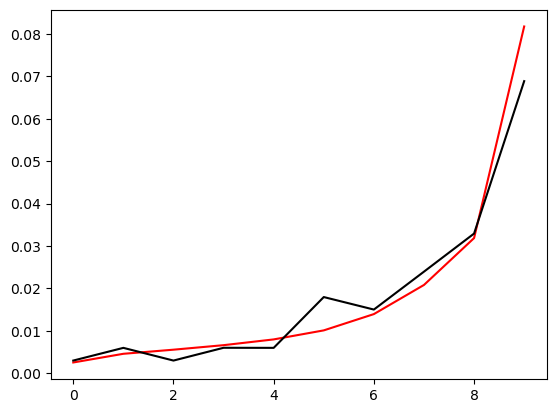

In [68]:
print(sba_3b_df[['sba_3b_pred', 'sba_3b']].mean())

# Create figures
plt.plot(sba_3b_df_quantiles['quantile'], sba_3b_df_quantiles['sba_3b_pred'], color='red')
plt.plot(sba_3b_df_quantiles['quantile'], sba_3b_df_quantiles['sba_3b'], color='black')
plt.show() 

##### Steal 2B

In [75]:
%%time
# Select relevant columns and handle missing values
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1').query('year >= 2023')[['outs_pre', 'sba_imp', 'sb_imp']]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1').query('year >= 2023')['sb_2b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
predict_sb_2b = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='relu', max_iter=100, random_state=200000)
predict_sb_2b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_sb_2b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sb_2b_not', 'sb_2b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M05. Steals", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sb_2b, open(os.path.join(model_path, "M05. Steals", todaysdate, "predict_sb_2b.sav"), 'wb'))

CPU times: total: 6.91 s
Wall time: 5.41 s


In [76]:
quantiles = 10

# Add xtiles (to examine how well predictions match actual results)
sb_2b_df['quantile'] = pd.qcut(sb_2b_df['sb_2b_pred'], quantiles, labels=False)
globals()["sb_2b_df"] = sb_2b_df.groupby('quantile')[['sb_2b', 'sb_2b_pred']].mean().reset_index()

sb_2b_pred   0.7866
sb_2b        0.7953
dtype: float64


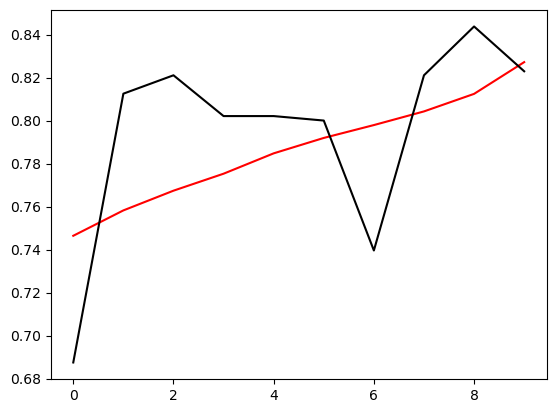

In [77]:
print(sb_2b_df[['sb_2b_pred', 'sb_2b']].mean())

# Create figures
plt.plot(sb_2b_df['quantile'], sb_2b_df['sb_2b_pred'], color='red')
plt.plot(sb_2b_df['quantile'], sb_2b_df['sb_2b'], color='black')
plt.show() 

##### Steal 3B

In [ ]:
%%time
# Select relevant columns and handle missing values
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2').query('year >= 2023')[['outs_pre', 'sba_imp', 'sb_imp']]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2').query('year >= 2023')['sb_3b']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2000020)

# Create and train the MLPClassifier
predict_sb_3b = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', max_iter=1000, random_state=random.randint(10000,100420))
predict_sb_3b.fit(X_train, y_train)

# Get probability predictions on the test set
probabilities = predict_sb_3b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sb_3b_not', 'sb_3b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

# Create directory
os.makedirs(os.path.join(model_path, "M05. Steals", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sb_3b, open(os.path.join(model_path, "M05. Steals", todaysdate, "predict_sb_3b.sav"), 'wb'))

In [ ]:
quantiles = 10

# Add xtiles (to examine how well predictions match actual results)
sb_3b_df['quantile'] = pd.qcut(sb_3b_df['sb_3b_pred'], quantiles, labels=False)
globals()["sb_3b_df"] = sb_3b_df.groupby('quantile')[['sb_3b', 'sb_3b_pred']].mean().reset_index()

In [ ]:
print(sb_3b_df[['sb_3b_pred', 'sb_3b']].mean())

# Create figures
plt.plot(sb_3b_df['quantile'], sb_3b_df['sb_3b_pred'], color='red')
plt.plot(sb_3b_df['quantile'], sb_3b_df['sb_3b'], color='black')
plt.show() 

In [ ]:
df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2').query('year >= 2023').shape